<a href="https://colab.research.google.com/github/Muftawo/RFB-assessment/blob/main/RainForestBuilder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> **Company Name:** [Rainforest Builder](https://www.rainforestbuilder.com/)  <br>
> **Project:** Rainforest Biomass Predictor Assessment <br>
> **Applicant:** Muftawo Omar<br>
> **Email:** muftawoomar@gmail.com <br>
> **Website:**  [here](https://muftawo.github.io/) <br>
> **Github:**  [here](https://github.com/Muftawo) <br>




## Table of Contents

1. [Overview](#overview)
2. [Project Goal](#project-goal)
3. [Dataset](#dataset)
4. [Methodology](#methodology)  
   4.1. [Exploratory Data Analysis](#exploratory-data-analysis)  
   4.2. [Data Preparation](#data-preparation)  
   4.3. [Model Fitting](#model-fitting)  
      * [Algorithm Evaluation](#algorithm-evaluation)  
      * [Parameter Tuning](#parameter-tuning)  
      * [Final Model](#final-model)

   4.4. [Model Evaluation](#model-evaluation)  
      - [Model Understanding](#model-understanding)  
   
   4.5. [Biomass Prediction](#biomass-prediction)
5. [Conclusion](#conclusion)  
   5.1. [Summary of Findings](#summary-of-findings)  
   5.2. [Implications for Restoration Activities](#implications-for-restoration-activities)  
   5.3. [Challenges and Limitations](#challenges-and-limitations)  
   5.4. [Future Work](#future-work)  
   5.5. [Practical Implementation](#practical-implementation)


# Overview

Rainforest Builder's primary restoration focus is on the Upper Wassaw (UW) forest reserve, a closed-canopy tropical lowland forest. Typically, such forests reach an average height of over 50 meters and store approximately 700-800 Mg CO2 per hectare. However, the UW reserve faces significant threats from illegal logging, agricultural conversion, and galamsey (illegal mining).

## Project Goal

Between August 2023 and August 2024, Rainforest Builder conducted an extensive survey, measuring aboveground biomass at 107 randomly selected sample plots across the reserve. The central question guiding this project is:

  ***Can we create a predictive model of biomass using multispectral imagery?***

This notebook outlines the approach employed to answer this question.

## Breif About Dataset
The dataset for this project is contained within  `data_budle.zip` which includes:
1.  **Biomass Data:** ESRI shapefiles (e.g., point_data.shp) containing biomass data from the sample plots.
2. **Multispectral Imagery:** A raster file (Sentinel_2_composite_UW_late2023.tif) from late 2023, covering the area used for field inventories.

3. **Pre-extracted Features:** A CSV file (full_dataset.csv) containing extracted multispectral features as an alternative to feature extraction through code.

## Methodology

The methodology that I will be using for this project is largely dependent on the project goal discussed above. The methodlogy framework below gives us a comprehensive guide on the apparoach that will help in achieving project goal.


1. Exploratory Data Analysis
  * Data Quality Assessment
  * Descriptive Statistics
  * Data Analysis

2. Data Preparation
  * Data Cleaning and Preprocessing
  * Feature Engineering and Selection
  * Splitting Dataset

3. Model Fitting
  * Initial Model Training
  * Algorithm Evaluation
    * Testing various algorithms and comparing performance.
  * Parameter Tuning
    * Optimizing model hyperparameters to improve performance.
  * Final Model
    * Selecting and training the final model based on evaluation.

4. Model Evalution:
  * Assessing the final model’s performance using evaluation metrics.
   * Model Understanding
    * Interpreting model predictions and understanding the key features driving biomass predictions.

5. Biomass Prediction
 * Applying the final model across the full raster extent to generate biomass estimates.


## Conclusion
  * Summary of Findings
  * Implications for Restoration Activities
  * Challenges and Limitations
  * Future Work
  * Practical Implementation







---
# Methodology
---


### Exploratory Data Analysis (EDA)

In this section, we will explore our dataset to gain insights and enhance our overall understanding of the data. This will include the following steps:

1. Data Quality Analysis
2. Descriptive Statistics
3. Data Analysis


We will start by unzipping the dataset into the project directory, followed by an exploration of the available files using Python.

Also note that we will explore the shape file first before we take a look at the multispectral image.

In [ ]:
## Unzip data_bundle :TODO please change the paths to accordingly
!unzip /content/drive/MyDrive/2024/data_bundle.zip -d '/content/drive/MyDrive/2024/'

In [2]:
# install required packages
!pip install geopandas rasterio shapely scikit-learn numpy pandas matplotlib  pydeck

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 94.2 MB/s eta 0:00:00


### Shapefile EDA

The shapefile extracted `point_data.shp` contains data from our 107 surveyed plots, a scaled `biomass` score between 0 and 1, and polygon of each plot.

I first load the data into a GeoPandasDataFrame and perform some plimeary data quality checks. This includes
1. Inspect the CRS
2. Inspect the total Sample plots
3. Inspect for missing values
4. Inspect the distribution of Biomas
5. Look out for Outliers

I will use some descriptive statistics and visualizations to explore for insights in the data.


In [64]:
# module imports
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import rasterio

from shapely.geometry import Point

from pyproj import Transformer

import pydeck as pdk
import matplotlib.colors as mcolors


In [4]:

base_path = '/content/drive/MyDrive/2024/data_bundle/'

# Loading the Biomass Data (Shapefile)
shapefile_path = f"{base_path}/point_data.shp"
biomass_data = gpd.read_file(shapefile_path)



In [5]:
# Inspect the first few rows of the biomass data
print("Biomass Data (First 5 Rows):")
biomass_data.head()


Biomass Data (First 5 Rows):


biomass                                           geometry
0  0.304348  POLYGON ((590105.692 678320.723, 590105.692 67...
1  0.086957  POLYGON ((588919.456 679079.536, 588919.456 67...
2  0.086957  POLYGON ((588736.222 678933.11, 588736.222 678...
3  0.043478  POLYGON ((588248.183 679048.24, 588248.183 679...
4  0.130435  POLYGON ((588618.928 679005.575, 588618.928 67...

In [6]:
# Confrim Coordinate Reference System (CRS)
print("CRS of Biomass Data:", biomass_data.crs)

CRS of Biomass Data: EPSG:32630


In [7]:
#Confirm we have data from 107 sample plots
print("Total count of Sample Plots in dataset:", biomass_data.shape[0])

Total count of Sample Plots in dataset: 110


In [8]:
# Calculate the area of each polygon in square meters
biomass_data['area'] = biomass_data['geometry'].area

# Display the calculated areas
biomass_data.head()


biomass                                           geometry    area
0  0.304348  POLYGON ((590105.692 678320.723, 590105.692 67...  1600.0
1  0.086957  POLYGON ((588919.456 679079.536, 588919.456 67...  1600.0
2  0.086957  POLYGON ((588736.222 678933.11, 588736.222 678...  1600.0
3  0.043478  POLYGON ((588248.183 679048.24, 588248.183 679...  1600.0
4  0.130435  POLYGON ((588618.928 679005.575, 588618.928 67...  1600.0

In [9]:
biomass_data.area.describe()


count     110.0
mean     1600.0
std         0.0
min      1600.0
25%      1600.0
50%      1600.0
75%      1600.0
max      1600.0
dtype: float64

In [10]:
biomass_data.drop("area", axis=1 ,inplace=True)

It is obersed that all our sample plots are of the same area, that is 1600 square meters. This tells us that size of plots is not a contributing factor in the the disparity of biomass per plot.

In [11]:
# Perform basic data quality checks
print("Missing Values in Biomass Data:")
print(biomass_data.isnull().sum())

Missing Values in Biomass Data:
biomass     3
geometry    0
dtype: int64



While we have coordinates for a total of 110 sample plots, we are missing the corresponding biomass data for 3 of these plots. This confirms that we have data for the expected 107 plots.

I will visualize and examine the locations of these missing data plots relative to the others to inform my decision on how to handle them.



<ipython-input-12-ec7425fe80b9>:16: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


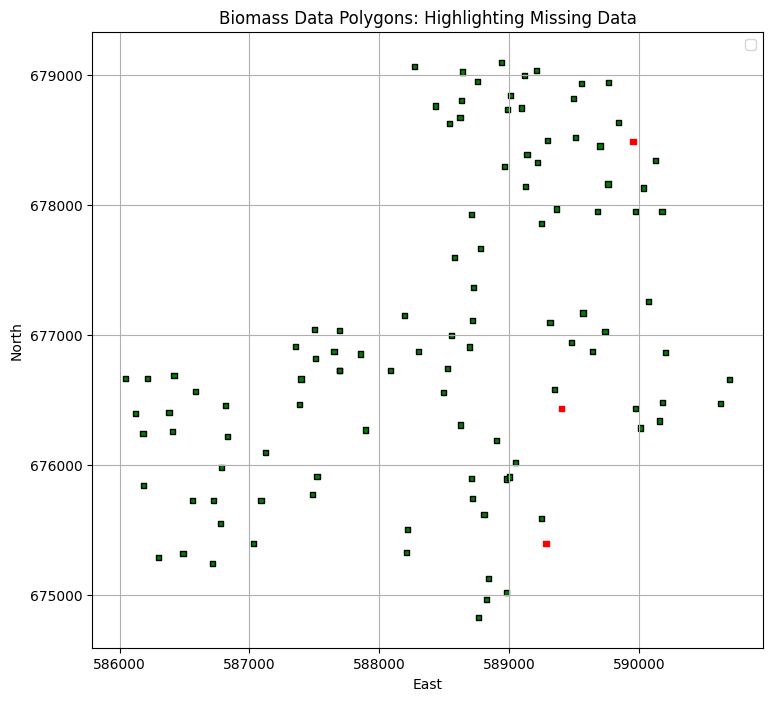

In [12]:
##  missing values

biomass_data['missing_biomass'] = biomass_data['biomass'].isnull()


fig, ax = plt.subplots(figsize=(12, 8))

# Plot all polygons with color codes, 'red' for missing biomass data, 'green' for available data
biomass_data[biomass_data['missing_biomass']].plot(ax=ax, color='red', label='Missing Biomass', edgecolor='red')
biomass_data[~biomass_data['missing_biomass']].plot(ax=ax, color='green', label='Available Biomass', edgecolor='black')


plt.title('Biomass Data Polygons: Highlighting Missing Data')
plt.xlabel('East')
plt.ylabel('North')
plt.legend()
plt.grid()
plt.show()

# drop new column
biomass_data = biomass_data.drop('missing_biomass', axis=1)


Given that we have 3 missing values out of 110, which represents approximately 2.7%, and that these missing plots are not concentrated in any specific area, I will proceed to drop them to simplify the dataset.

If the number of missing values had been higher, I would consider employing interpolation techniques to estimate the expected biomass for these plots.

In [13]:
biomass_data.dropna(inplace=True)

In [14]:
biomass_data.shape

(107, 2)

### Target Variable

The independent variable we are trying to predict is `biomass`. In the follwing steps I will probe futther to understand at its distribuition

In [15]:
print("Summary Statistics of Biomass Data:")
print(biomass_data.describe())

Summary Statistics of Biomass Data:
          biomass
count  107.000000
mean     0.238115
std      0.231406
min      0.000000
25%      0.043478
50%      0.130435
75%      0.369565
max      1.000000


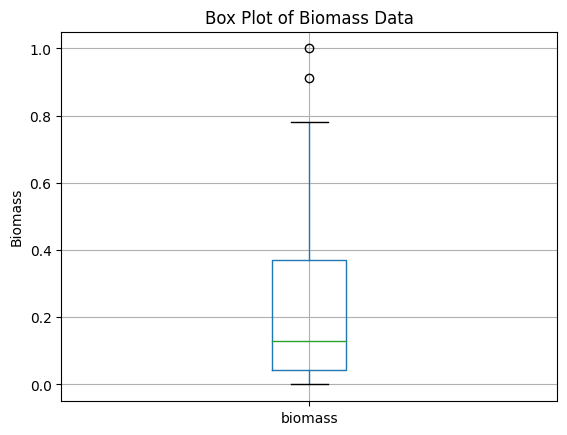

In [16]:
# plot box
biomass_data.boxplot(column='biomass')
plt.title('Box Plot of Biomass Data')
plt.ylabel('Biomass')
plt.show()


In [17]:

print("Investigating nth percentiles of biomass:")
biomass_data['biomass'].quantile([0.75, 0.90, 0.95, ])

Investigating nth percentiles of biomass:


0.75    0.369565
0.90    0.608696
0.95    0.682609
Name: biomass, dtype: float64

Biomass Statistical Summary:

count    107.000000
mean       0.238115
std        0.231406
min        0.000000
25%        0.043478
50%        0.130435
75%        0.369565
max        1.000000
Name: biomass, dtype: float64
Median biomass: 0.130434782608696
Skewness: 1.1274801619322032


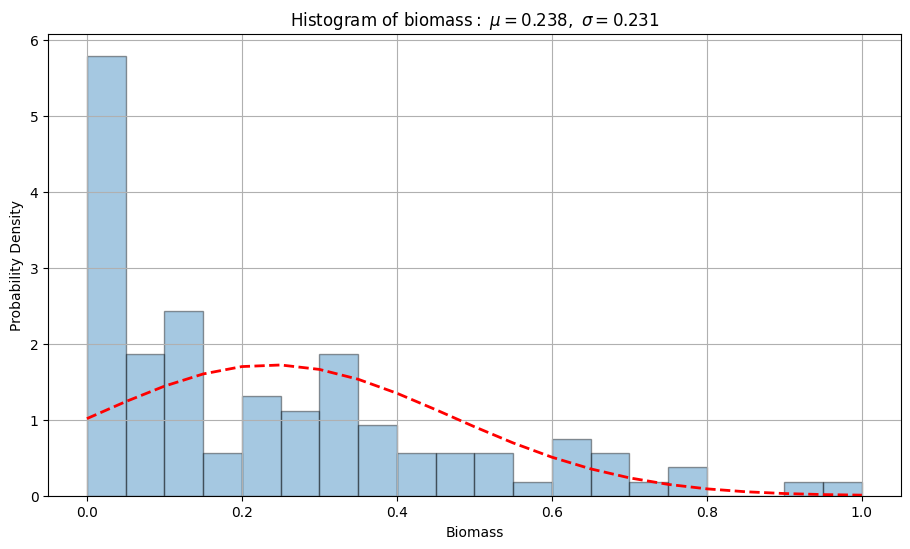

In [20]:
# Statistical Summary
print("Biomass Statistical Summary:\n")
print(biomass_data['biomass'].describe())
print("Median biomass:", biomass_data['biomass'].median())
print('Skewness:', biomass_data['biomass'].skew())

# Mean and standard deviation
mu = biomass_data['biomass'].mean()
sigma = biomass_data['biomass'].std()



# Histogram of biomass
num_bins = 20
plt.figure(figsize=(11, 6))
n, bins, patches = plt.hist(biomass_data['biomass'], num_bins, edgecolor='black', lw=1, alpha=0.40, density=True)

# Normal Distribution
y = norm.pdf(bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)

plt.xlabel('Biomass')
plt.ylabel('Probability Density')
plt.title(r'$\mathrm{Histogram\ of\ biomass:}\ \mu=%.3f,\ \sigma=%.3f$' % (mu, sigma))
plt.grid(True)
plt.show()


In [21]:

print("Investigating nth percentiles of biomass:")
biomass_data['biomass'].quantile([0.75, 0.90, 0.95, ])

Investigating nth percentiles of biomass:


0.75    0.369565
0.90    0.608696
0.95    0.682609
Name: biomass, dtype: float64

In [22]:
# De
q1 = biomass_data['biomass'].quantile(0.25)
q3 = biomass_data['biomass'].quantile(0.75)
iqr = q3 - q1
lw = q1 - 1.5 * iqr
uw = q3 + 1.5 * iqr

# Outliers are below the lower whisker OR above the upper whisker
outliers = (biomass_data['biomass'] < lw) | (biomass_data['biomass'] > uw)

biomass_data[outliers]

biomass                                           geometry
51  1.000000  POLYGON ((590055.766 677238.54, 590055.766 677...
91  0.913043  POLYGON ((588606.041 676286.757, 588606.041 67...

To appretiate the geographical distribuition of biomass accross the plots, I will use deck gl to visualize the distribuiton of biomass.

In [23]:

# Helper Function to convert the geometry centroids from projected to lat/lon for 3d visualization purpose

transformer = Transformer.from_crs('epsg:32630', 'epsg:4326')


def convert_to_latlon(geometry):
    x, y = geometry.x, geometry.y
    lon, lat = transformer.transform(x, y)
    return lat, lon

biomass_data['centriods'] =biomass_data['geometry'].centroid
biomass_data['longitude'], biomass_data['latitude'] = zip(*biomass_data['centriods'].apply(convert_to_latlon))
biomass_data.drop('centriods', axis=1, inplace=True)


biomass_data.head()

biomass                                           geometry  longitude  \
0  0.304348  POLYGON ((590105.692 678320.723, 590105.692 67...  -2.185454   
1  0.086957  POLYGON ((588919.456 679079.536, 588919.456 67...  -2.196164   
2  0.086957  POLYGON ((588736.222 678933.11, 588736.222 678...  -2.197822   
3  0.043478  POLYGON ((588248.183 679048.24, 588248.183 679...  -2.202231   
4  0.130435  POLYGON ((588618.928 679005.575, 588618.928 67...  -2.198881   

   latitude  
0  6.136307  
1  6.143187  
2  6.141865  
3  6.142913  
4  6.142522

In [24]:


# Apply the custom red-to-green colormap to the biomass data
norm = mcolors.Normalize(vmin=biomass_data['biomass'].min(), vmax=biomass_data['biomass'].max())
cmap = mcolors.LinearSegmentedColormap.from_list("red_green", ["red", "yellow", "green"])

biomass_data['color'] = biomass_data['biomass'].apply(lambda x: [int(c*255) for c in cmap(norm(x))[:3]])

# Scale the heights for visibility
biomass_data['height'] = (biomass_data['biomass'] * 100).round(2)


layer = pdk.Layer(
    "ColumnLayer",
    data=biomass_data,
    get_position=["longitude", "latitude"],
    get_fill_color="color",
    get_radius=50,
    radius=50,
    elevation_scale=30,
    get_elevation='height',
     pickable=True,
    auto_highlight=True,
)

# Set the viewport
view_state = pdk.ViewState(
    latitude=biomass_data['latitude'].mean(),
    longitude=biomass_data['longitude'].mean(),
    zoom=12,
    pitch=45,
    bearing=0,
)


view = pdk.data_utils.compute_view(biomass_data[["longitude", "latitude"]])
view.pitch = 75
view.bearing = 60

tooltip = {
    "html": " Biomass <b>{height} %</b>",
    "style": {"background": "grey", "color": "white", "font-family": '"Helvetica Neue", Arial', "z-index": "10000"},
}

r = pdk.Deck(
    layers=[layer],
    initial_view_state=view_state,
    tooltip=tooltip,

)

r.show()


#remove unnessacry columns
biomass_data.drop('color', axis=1, inplace=True)
biomass_data.drop('height', axis=1, inplace=True)

<IPython.core.display.Javascript object>



### Biomass Distribution Summary

The distribution of the scaled biomass scores indicates a low biomass concentration across the different plots. With a mean of `23.81%` and a median of `13.04%`, more than `50%` of the `107` plots have a biomass below `13.04%`. Additionally, the 75th percentile of biomass concentration is approximately `36.95%`, indicating that three-quarters of the plots have biomass concentrations below this level.

At the higher end of the distribution, we observe that at the 90th percentile, the surveyed biomass is above `60%`, and at the 95th percentile, it reaches `68.26%`. Furthermore, a few outliers show exceptionally high biomass concentrations, including instances of `100%` biomass in some plots.

Further visualizations of the forest reserve, focusing on biomass distribution, reveal a concentration of plots with low levels of biomass that appear to be skewed toward specific parts of the forest reserve.

Further investigations regarding the outliers indicate that there are two plots with high biomass percentages of `91%` and `100%`. The visualization also shows that the plot with `91%` biomass is located in an area of the reserve with relatively high levels of biomass, while the `100%` plot is not. Therefore, I will exclude only the `100%` biomass plot from the dataset to streamline the analysis moving forward.






### Summary of Shape file EDA

After exploring out shape file, some key insighs uncovered include.
1. The data contained a total of 110 plots but 3 had no biomass data bringing our tally to 107.
2. The data had one main outlier with `100 %` biomass score
3. A majority of our plots had low biomass score. with a mean median of `23.81%` and `13.04%` respectively
4. A concentration of plots with low levels of biomass we skewed towards a specific region
5. After data cleaning our data now has `106` plots
6. Calculating the area of each plot indicated plots are of equal sizes of `1600` square meters


With this aspect complete, the next is to continue our EDA on the multispectral image

In [25]:
biomass_data = biomass_data[biomass_data['biomass'] != 1]

In [26]:
biomass_data.shape

(106, 4)

## Raster EDA

After exploring the biomass data I proceed with exploration of the serinel-2 image.

I begin by printing out some information about the multispectral image and then define some helper functions that will be used to vizualize our image and overlay polygons.

In [27]:
raster_path = f"{base_path}/Sentinel_2_composite_UW_late2023.tif"


# Print metadata to understand the structure of the raster
with rasterio.open(raster_path) as src:

    print("Multispectral Imagery Info:")

    print(f"src.profile: {src.profile}")
    print("="*100)

    print(f"Meta Data:  {src.meta}")
    print("="*100)

    # Get the number of bands
    print(f"Total Number of bands: {src.count}")
    print("="*100)

    print(f"Tags: {src.tags}")
    print("="*100)




Multispectral Imagery Info:
src.profile: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 823, 'height': 841, 'count': 23, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.983152841195215e-05, 0.0, -2.2276422415595896,
       0.0, -8.983152841195215e-05, 6.17178532801476), 'blockxsize': 823, 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}
Meta Data:  {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 823, 'height': 841, 'count': 23, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.983152841195215e-05, 0.0, -2.2276422415595896,
       0.0, -8.983152841195215e-05, 6.17178532801476)}
Total Number of bands: 23
Tags: <bound method DatasetBase.tags of <open DatasetReader name='/content/drive/MyDrive/2024/data_bundle//Sentinel_2_composite_UW_late2023.tif' mode='r'>>


<ipython-input-26-8fb81d37bccd>:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  biomass_data['centroid'] = biomass_data.centroid


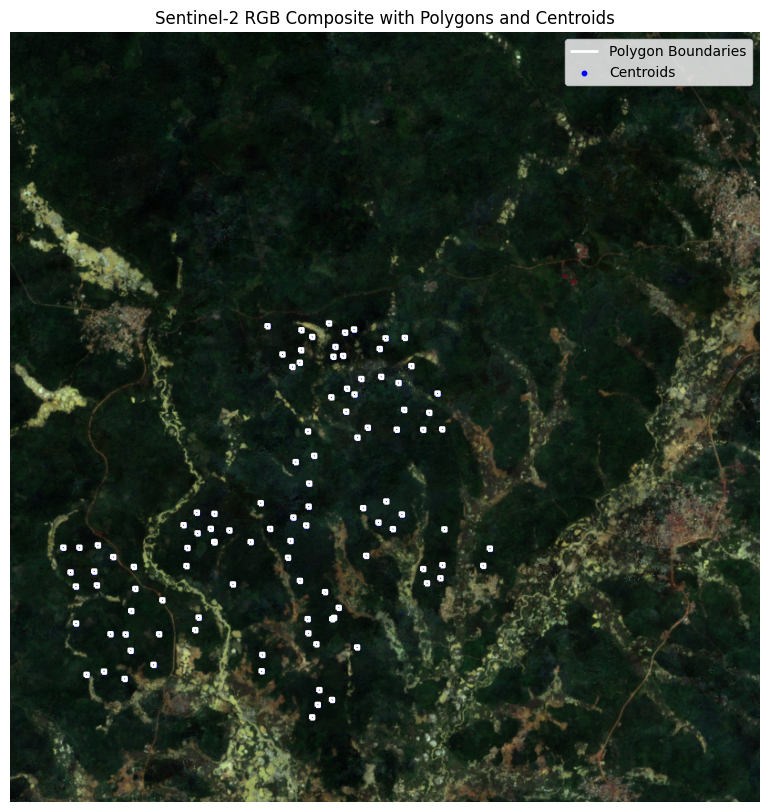

In [26]:

## helper functions

def normalize(band):
    """Normalize the input band to a range between 0 and 1."""
    band_min, band_max = band.min(), band.max()
    return (band - band_min) / (band_max - band_min)

def load_and_prepare_rgb(raster_path):
    """Load Sentinel-2 imagery bands (Red, Green, Blue), normalize them, and return an RGB composite."""
    with rasterio.open(raster_path) as src:
        # Read Red, Green, and Blue bands (Band 4, Band 3, Band 2 respectively)
        red_band = src.read(4)
        green_band = src.read(3)
        blue_band = src.read(2)

    # Normalize the bands
    red_n = normalize(red_band)
    green_n = normalize(green_band)
    blue_n = normalize(blue_band)

    # Stack the normalized bands into an RGB composite image
    rgb_image = np.dstack((red_n, green_n, blue_n))

    return rgb_image, src

def plot_rgb_with_polygons(rgb_image, biomass_data, src):
    """Plot the RGB composite image and overlay polygons with centroids."""
    # Transform the biomass_data CRS to match the raster CRS
    biomass_data = biomass_data.to_crs(src.crs)

    # Extract centroids
    biomass_data['centroid'] = biomass_data.centroid

    # Plot RGB image
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(rgb_image, extent=(src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top))

    # Plot polygon boundaries on the RGB image
    biomass_data.boundary.plot(ax=ax, edgecolor='white', linewidth=2, label='Polygon Boundaries')

    # Plot centroids
    biomass_data['centroid'].plot(ax=ax, color='blue', markersize=10, label='Centroids')

    # Add legend and title
    plt.legend()
    plt.title("Sentinel-2 RGB Composite with Polygons and Centroids")
    plt.axis('off')
    plt.show()




# Load and prepare the RGB image and raster source
rgb_image, src = load_and_prepare_rgb(raster_path)

# Plot the RGB image with polygon overlays
plot_rgb_with_polygons(rgb_image, biomass_data, src)


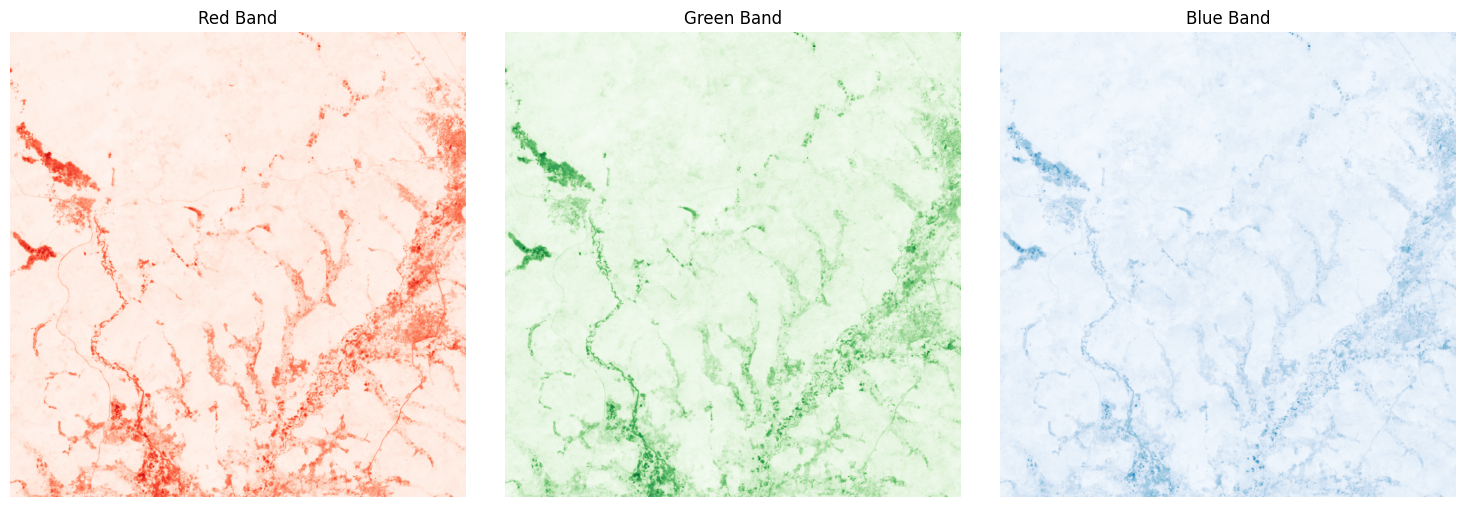

In [30]:

# plot only RGB bands
with rasterio.open(raster_path) as src:

    band_red = src.read(4)   # Band 4 (Red)
    band_green = src.read(3) # Band 3 (Green)
    band_blue = src.read(2)  # Band 2 (Blue)


fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Display Red Band
ax[0].imshow(band_red, cmap='Reds')
ax[0].set_title('Red Band')
ax[0].axis('off')

# Display Green Band
ax[1].imshow(band_green, cmap='Greens')
ax[1].set_title('Green Band')
ax[1].axis('off')

# Display Blue Band
ax[2].imshow(band_blue, cmap='Blues')
ax[2].set_title('Blue Band')
ax[2].axis('off')

plt.tight_layout()
plt.show()



In [33]:
# Define band titles and human-visible wavelength indicators
band_titles = ['Aerosol - Band 1', 'Blue - Band 2', 'Green - Band 3', 'Red - Band 4',
               'Red Edge - Band 5', 'Band 6', 'Band 7', 'NIR - Band 8', 'Band 9',
               'Band 10', 'SWIR 1 - Band 11', 'SWIR 2 - Band 12']

# Bands corresponding to human-visible wavelengths
visible_bands = {'Red - Band 4': 'Reds', 'Green - Band 3': 'Greens', 'Blue - Band 2': 'Blues'}



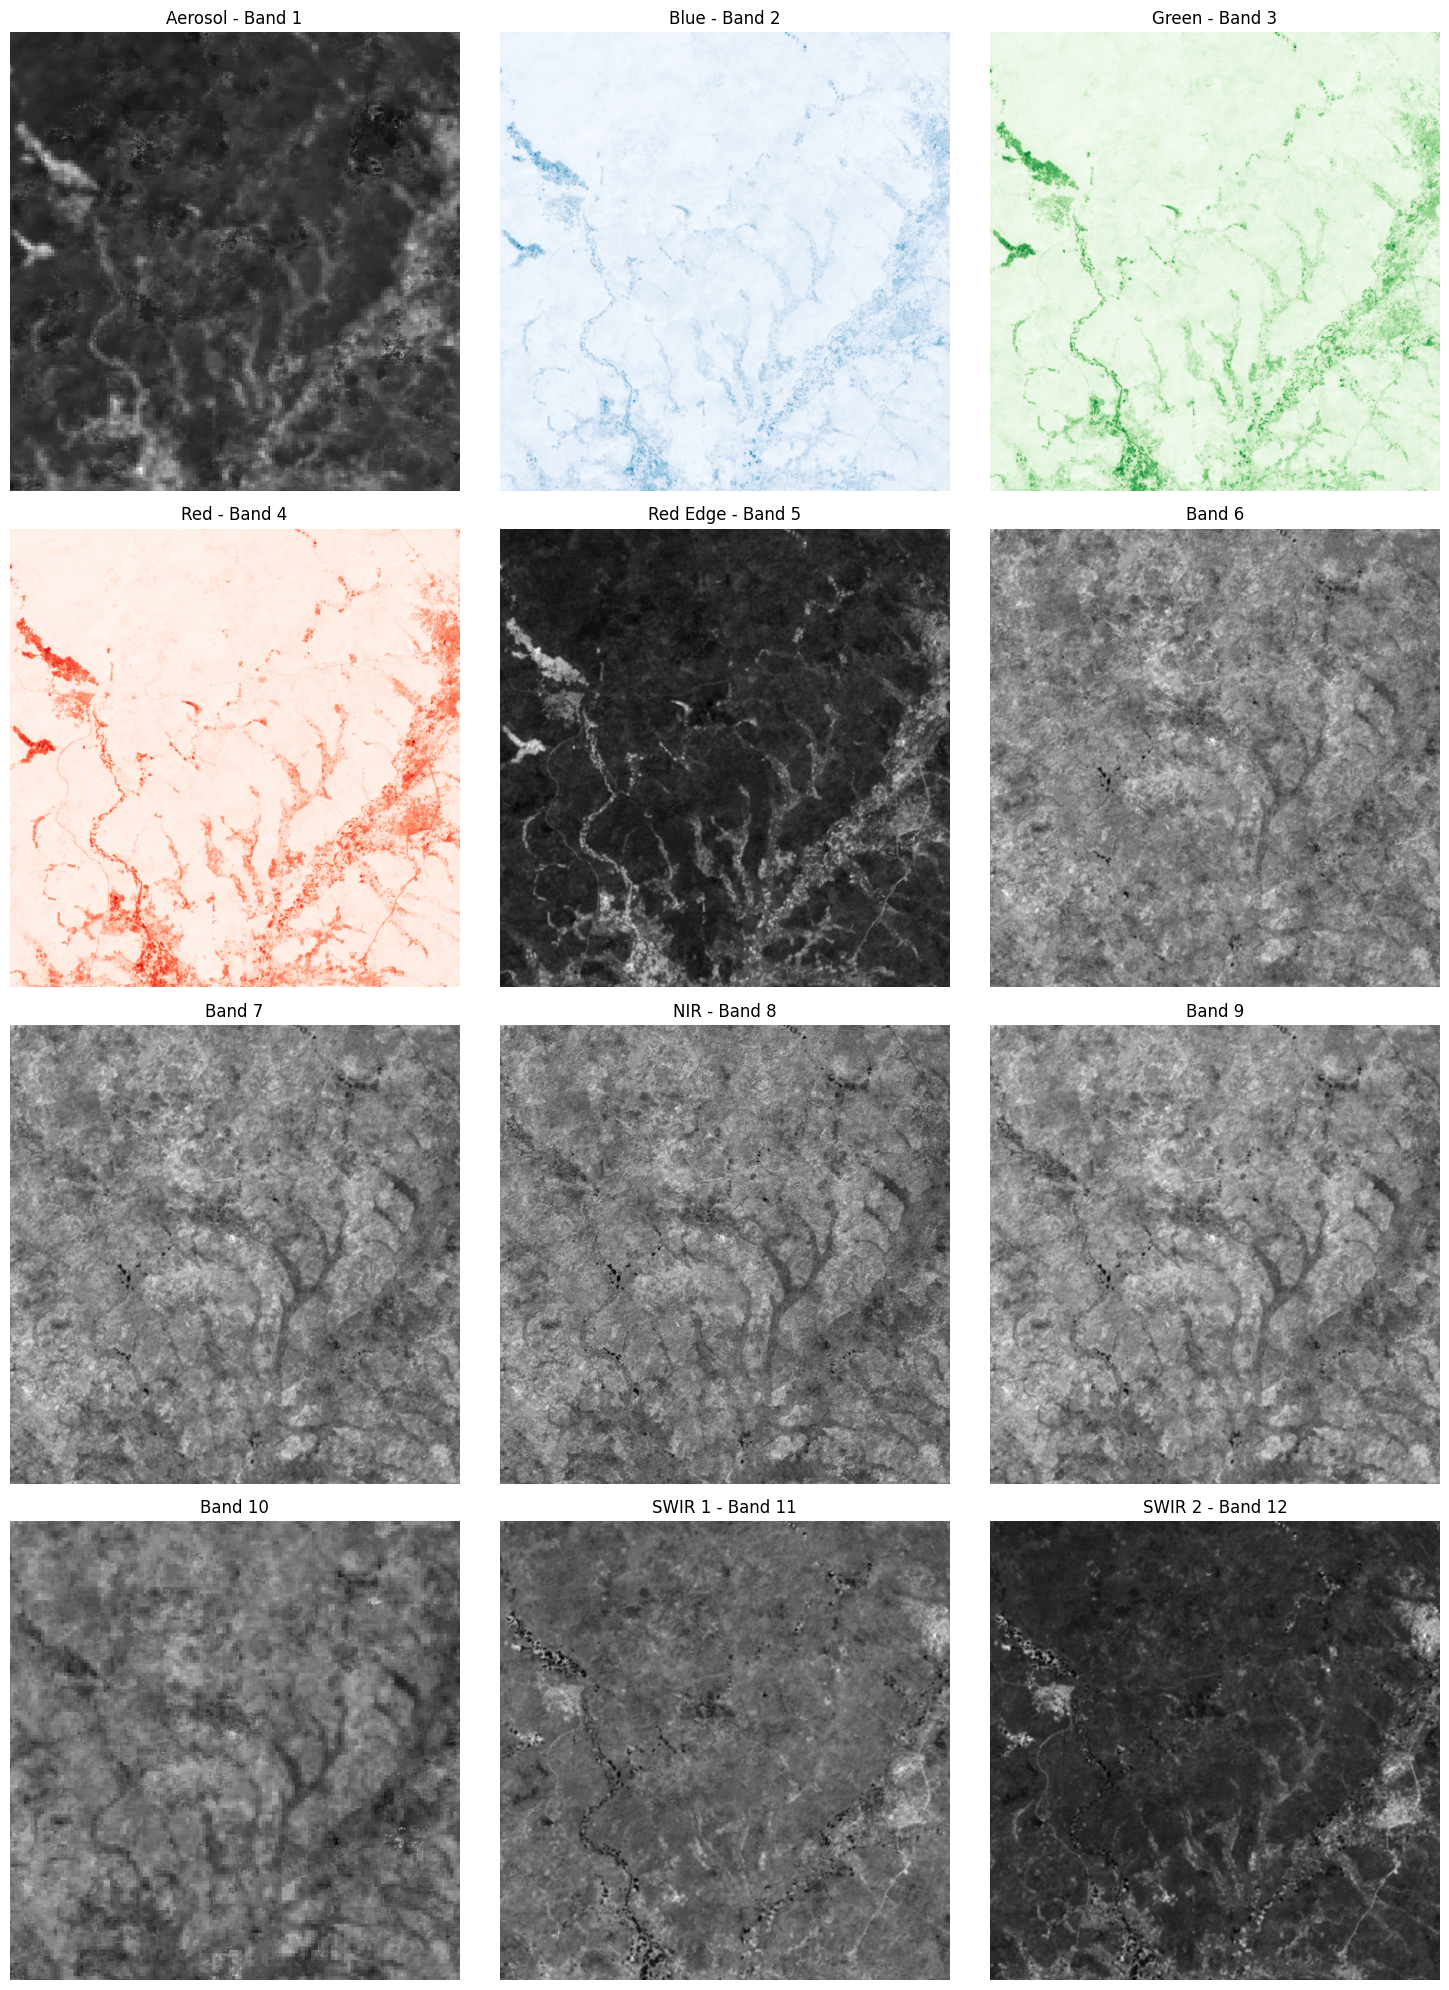

In [34]:
with rasterio.open(raster_path) as src:
    bands = [src.read(i+1) for i in range(len(band_titles))]

# Create subplots for each band 4 rows, 3 columns to accommodate 12 bands
fig, ax = plt.subplots(4, 3, figsize=(15, 20))
ax = ax.flatten()


for i, (band, title) in enumerate(zip(bands, band_titles)):
    if title in visible_bands:
        cmap = visible_bands[title]
    else:
        cmap = 'gray'

    # Plot the band
    ax[i].imshow(band, cmap=cmap)
    ax[i].set_title(title)
    ax[i].axis('off')

plt.tight_layout()
plt.show()



## Extract band features


 While there are 23 different bands in the raster I will limit our feature extraction to only the 12 listed in [here](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/bands/) for the purpose of this exercise.


After matching the CRS of the shapefile and image, I mask out the polygon and calculate the mean value per band.



In [35]:
from rasterio.mask import mask


def extract_raster_features_for_plots(raster_path, biomass_data):
    """
    Function to extract multispectral features
    """

    with rasterio.open(raster_path) as src:

        # match the crs
        biomass_data = biomass_data.to_crs(src.crs)

        # Initialize a list to store features for each plot
        features_list = []


        for idx, row in biomass_data.iterrows():
            # Extract the geometry (polygon)
            geom = [row['geometry']]
            biomass = row['biomass']


            # Extract the pixel values for the row geometry for all bands
            out_image, out_transform = mask(src, geom, crop=True)

            # Reshape to have bands in the first axis and flatten each band's pixels
            out_image = out_image.reshape(src.count, -1)

            # Initialize a dictionary to store statistics for this row
            row_feature_values = {'biomass': biomass}

            # Loop over all bands and calculate statistics
            for band_idx in range(len(band_titles)):
                band_data = out_image[band_idx]

                # Mask out NoData values
                band_data = band_data[band_data != src.nodata]

                if band_data.size > 0:
                    # Calculate the mean
                    row_feature_values[f'B{band_idx+1}'] = np.mean(band_data)

                else:
                    # If there are no valid data points, set NaNs
                    row_feature_values[f'B{band_idx+1}'] = np.nan


            features_list.append(row_feature_values)

    # Convert the list of features into a DataFrame
    features_df = gpd.GeoDataFrame(features_list)

    return features_df


raster_path = f"{base_path}/Sentinel_2_composite_UW_late2023.tif"

multispectral_features_df = extract_raster_features_for_plots(raster_path, biomass_data)


multispectral_features_df.head()



biomass           B1          B2           B3          B4           B5  \
0  0.304348  1015.719971  933.419983  1061.479980  899.919983  1272.020020   
1  0.086957   997.099976  952.320007  1119.959961  960.359985  1331.400024   
2  0.086957   997.340027  937.900024  1056.719971  914.039978  1322.199951   
3  0.043478   915.960022  965.940002  1060.699951  948.520020  1279.099976   
4  0.130435   929.679993  915.659973  1052.079956  923.099976  1288.760010   

            B6           B7           B8           B9          B10  \
0  2666.580078  3183.739990  3180.800049  3425.500000  3221.679932   
1  2118.139893  2403.820068  2427.159912  2608.699951  2592.040039   
2  2816.760010  3313.699951  3336.159912  3540.060059  3530.560059   
3  2185.639893  2495.100098  2511.000000  2678.800049  2630.179932   
4  2797.659912  3331.379883  3308.320068  3587.280029  3400.959961   

           B11          B12  
0  2032.239990  1296.079956  
1  2000.979980  1328.640015  
2  2119.760010  1342.040039  
3  1826.319946  1226.640015  
4  2066.080078  1299.260010

In [36]:
# any missing values
multispectral_features_df.isnull().sum()

biomass    0
B1         0
B2         0
B3         0
B4         0
B5         0
B6         0
B7         0
B8         0
B9         0
B10        0
B11        0
B12        0
dtype: int64

In [29]:
multispectral_features_df.shape

(106, 13)

In [30]:
save_path = f"{base_path}/extracted_features.csv"
multispectral_features_df.to_csv(save_path, index=False)


### Summary of Raster Image EDA

In this exploratory data analysis (EDA) step, we visualized all survey plots overlaid on the raster image. Individual band plots were generated, including a composite  human-visible wavelengths (RGB).

It was observed that the raster data contained 23 bands, beyond the expected 12 bands typical of Sentinel-2 imagery. However, for feature extraction, we focused on the 12 relevant bands necessary for this project.

While the current implementation targets these 12 bands, the code can be easily adjusted to facilitate feature extraction across all available bands.

#### Feature Extraction

For feature extraction across the bands for each plot, we masked the polygons over each band and calculated the mean of pixel values within each polygon as the feature value for that specific band. The dataset also contains the corresponding biomass score for each plot.

Finally, we saved the extracted feature dataset into `extracted_features.csv`, located in the project's `base_path`.

The next step involves preparing the data for model fitting.






---
# Data Preparation
---





Our main objective in this step is to prepare the data for model fitting. This involves the following key tasks:

1. **Final Cleaning and Preprocessing**: Ensuring that the data is free from inconsistencies, missing values, and irrelevant features that could affect model performance.
   
2. **Feature Engineering and Selection**: Transforming raw data into meaningful features for model input. This may involve creating new features from existing data or selecting the most relevant features to improve model accuracy and efficiency.

3. **Data Splitting**: Dividing the dataset into training and evaluation sets to assess model performance effectively. This typically includes a split into training, validation, and test datasets to avoid overfitting and ensure generalizability.

Once the data is fully preprocessed, we will proceed with model fitting and evaluation.



In [45]:
# 1.  Final Cleaning and Preprocessing

# Load the extracted features dataset with biomass
df = pd.read_csv(f'{base_path}/extracted_features.csv')

# print and remove duplicates if any
if count:= df.duplicated().sum():
  print(f"Number of duplicate rows: {count}")
  df = df.drop_duplicates()
else:
  print("No duplicate rows found")


# check for null values
if df.isnull().values.any():
  print(f"Number of NaN values : {df.isnull().values.sum()}")
  null_mask = df.isnull().any(axis=1)
  null_rows = df[null_mask]
  print("Rows with NaN values:")
  print(null_rows)
else:
  print("No NaN values found")


if (df.isnull().values.sum() > 0):
    df.dropna(inplace=True)
    print(f"Number of NaN values after drop : {df.isnull().values.sum()}")

print(f"the shape of df: {df.shape}")

No duplicate rows found
No NaN values found
the shape of df: (106, 13)


In [38]:
df.head()

biomass       B1      B2       B3      B4       B5       B6       B7  \
0  0.304348  1015.72  933.42  1061.48  899.92  1272.02  2666.58  3183.74   
1  0.086957   997.10  952.32  1119.96  960.36  1331.40  2118.14  2403.82   
2  0.086957   997.34  937.90  1056.72  914.04  1322.20  2816.76  3313.70   
3  0.043478   915.96  965.94  1060.70  948.52  1279.10  2185.64  2495.10   
4  0.130435   929.68  915.66  1052.08  923.10  1288.76  2797.66  3331.38   

        B8       B9      B10      B11      B12  
0  3180.80  3425.50  3221.68  2032.24  1296.08  
1  2427.16  2608.70  2592.04  2000.98  1328.64  
2  3336.16  3540.06  3530.56  2119.76  1342.04  
3  2511.00  2678.80  2630.18  1826.32  1226.64  
4  3308.32  3587.28  3400.96  2066.08  1299.26

### Target Variable (Biomass)



The distribution of our taget varibal `biomass` as we saw earlier is clearly right skewed  (mean > median). With most of plots recordign biomass near zero. To prevent the model from overfitting to the right, I consider engineering the target variable to make the distrubion appear more symmetric to reduce the influence of the skewness.

However, for the purpose of this assessment I will  consider leaving the variable as is without any transformation.



Biomass Statistical Summary:

count    106.000000
mean       0.230927
std        0.220178
min        0.000000
25%        0.043478
50%        0.130435
75%        0.347826
max        0.913043
Name: biomass, dtype: float64
Median biomass: 0.130434782608696
Skewness: 1.0192820638936866


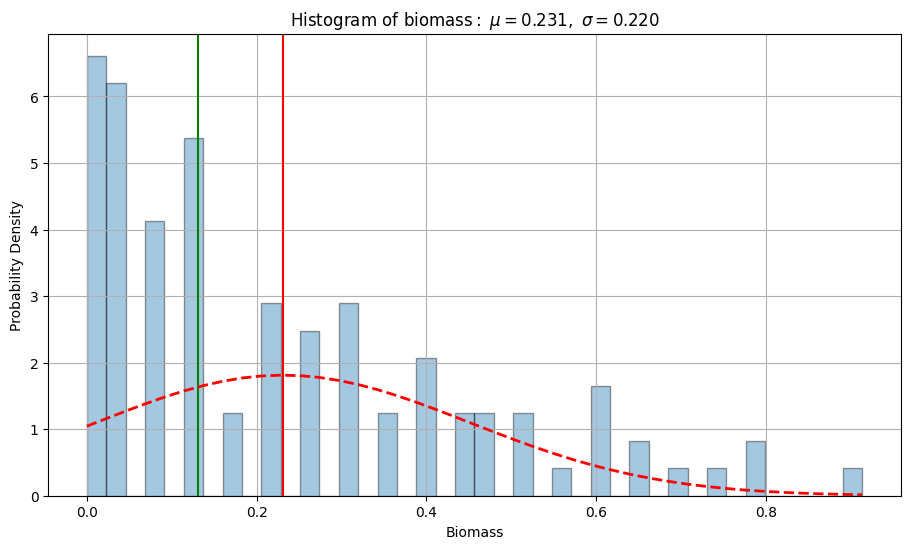

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Statistical Summary
print("Biomass Statistical Summary:\n")
print(df['biomass'].describe())
print("Median biomass:", df['biomass'].median())
print('Skewness:', df['biomass'].skew())

# Mean and standard deviation
mu = df['biomass'].mean()
sigma = df['biomass'].std()

num_bins = 40

# Histogram of biomass
plt.figure(figsize=(11, 6))
n, bins, patches = plt.hist(df['biomass'], num_bins, edgecolor='black', lw=1, alpha=0.40, density=True)
plt.axvline(x = df['biomass'].mean(), c = 'red')
plt.axvline(x = df['biomass'].median(), c = 'green')

# Normal Distribution
y = norm.pdf(bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)

plt.xlabel('Biomass')
plt.ylabel('Probability Density')
plt.title(r'$\mathrm{Histogram\ of\ biomass:}\ \mu=%.3f,\ \sigma=%.3f$' % (mu, sigma))
plt.grid(True)
plt.show()


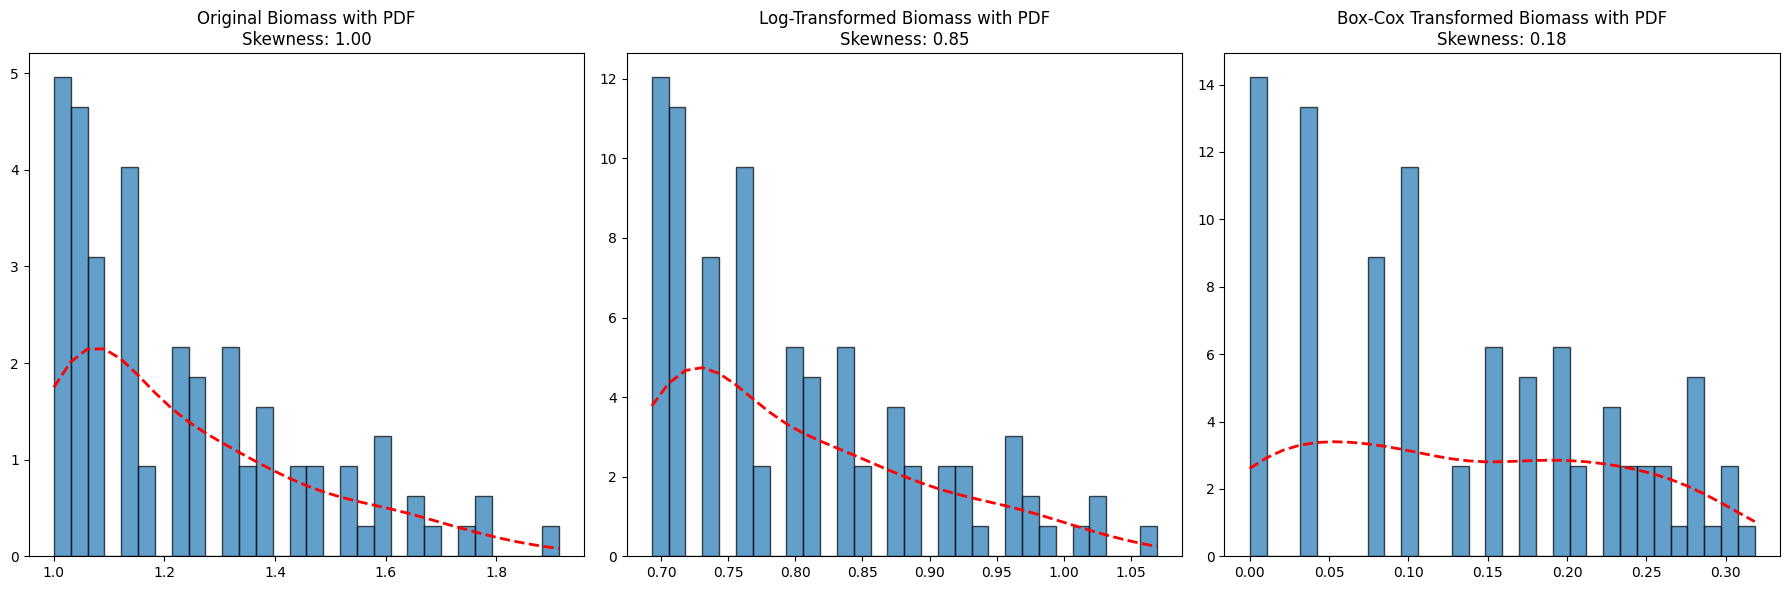

In [69]:

from scipy.stats import boxcox, gaussian_kde, skew


# Ensure the data is positive and shift if necessary
min_value = df['biomass'].min()
if min_value <= 0:
    df['biomass_shifted'] = df['biomass'] - min_value + 1
else:
    df['biomass_shifted'] = df['biomass']

# Apply Box-Cox Transformation
biomass_boxcox, fitted_lambda = boxcox(df['biomass_shifted'])
df['biomass_boxcox'] = biomass_boxcox

# Apply Log Transformation (log(x + 1) to handle zero values safely)
df['biomass_log'] = np.log1p(df['biomass_shifted'])

# Visualize the distribution and overlay PDF for Original, Log, and Box-Cox Transformed data
plt.figure(figsize=(18, 6))

# Original biomass histogram with PDF
plt.subplot(1, 3, 1)
n, bins, patches = plt.hist(df['biomass_shifted'], bins=30, density=True, alpha=0.7, edgecolor='black')
kde = gaussian_kde(df['biomass_shifted'])
pdf_values = kde(bins)
plt.plot(bins, pdf_values, 'r--', linewidth=2)
plt.title(f'Original Biomass with PDF\nSkewness: {skew(df["biomass_shifted"]):.2f}')

# Log-transformed biomass histogram with PDF
plt.subplot(1, 3, 2)
n_log, bins_log, patches_log = plt.hist(df['biomass_log'], bins=30, density=True, alpha=0.7, edgecolor='black')
kde_log = gaussian_kde(df['biomass_log'])
pdf_values_log = kde_log(bins_log)
plt.plot(bins_log, pdf_values_log, 'r--', linewidth=2)
plt.title(f'Log-Transformed Biomass with PDF\nSkewness: {skew(df["biomass_log"]):.2f}')

# Box-Cox transformed biomass histogram with PDF
plt.subplot(1, 3, 3)
n_boxcox, bins_boxcox, patches_boxcox = plt.hist(df['biomass_boxcox'], bins=30, density=True, alpha=0.7, edgecolor='black')
kde_boxcox = gaussian_kde(df['biomass_boxcox'])
pdf_values_boxcox = kde_boxcox(bins_boxcox)
plt.plot(bins_boxcox, pdf_values_boxcox, 'r--', linewidth=2)
plt.title(f'Box-Cox Transformed Biomass with PDF\nSkewness: {skew(df["biomass_boxcox"]):.2f}')

plt.tight_layout()
plt.show()




### Features Engineering

In this phase, we will perform feature engineering to enhance the predictive power of our dataset. Ideas used in this stage is highly influenced by information [here](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/bands/). Below are some key considereations:

1. **Band Averages**:
   - We have extracted mean values for each of the 12 Sentinel-2 bands across each plot. These values will serve as key predictors  for biomass concentration.

2. **Vegetation Indices**:
   - **Normalized Difference Vegetation Index (NDVI)**: NDVI can be calculated using the formula `(NIR - Red) / (NIR + Red)` where NIR is from Band 8 and Red is from Band 4. This is a crucial index in biomass estimation as it reflects vegetation health.
   - **Enhanced Vegetation Index (EVI)**: Another index that can be calculated using the formula `2.5 * (NIR - Red) / (NIR + 6 * Red - 7.5 * Blue + 1)` using Bands 8, 4, and 2. It is used to enhance vegetation signals while minimizing atmospheric influences.

3. **Band Ratios**:
   - **Ratio between Red and NIR Bands**: Calculating the ratio between Red (Band 4) and NIR (Band 8) may provide additional insights into biomass differences across plots.
   - **Green and Red Edge Bands**: Use the ratios of Band 3 (Green) to Band 5 (Red Edge) for feature generation, which is particularly useful in distinguishing different vegetation types.


4. **Interaction Terms**:
   - Create interaction terms between the extracted bands and the calculated vegetation indices to capture relationships that may not be obvious through simple linear features.



These engineered features will be included in the final dataset, which will serve as the input for model training and prediction.



The next step will be to estimated the feature importance and remove the variables that are not good predictors of biomas


In [51]:

# Calculate Vegetation Indices
def calculate_ndvi(band_nir, band_red):
    """Calculate NDVI (Normalized Difference Vegetation Index)."""
    return (band_nir - band_red) / (band_nir + band_red)

def calculate_evi(band_nir, band_red, band_blue):
    """Calculate EVI (Enhanced Vegetation Index)."""
    return 2.5 * (band_nir - band_red) / (band_nir + 6 * band_red - 7.5 * band_blue + 1)


# Calculate NDVI and EVI using Bands 8 (NIR), 4 (Red), and 2 (Blue)
df['NDVI'] = calculate_ndvi(df['B8'], df['B4'])
df['EVI'] = calculate_evi(df['B8'], df['B4'], df['B2'])

# Step 2: Calculate Band Ratios
df['Red_NIR_Ratio'] = df['B4'] / df['B8']
df['Green_RedEdge_Ratio'] = df['B3'] / df['B5']


# Step 3: Create Interaction Terms (optional, depending on model requirements)
df['NDVI_Band8_Interaction'] = df['NDVI'] * df['B8']
df['EVI_Band4_Interaction'] = df['EVI'] * df['B4']


In [57]:
df.columns

Index(['biomass', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10',
       'B11', 'B12', 'NDVI', 'EVI', 'Red_NIR_Ratio', 'Green_RedEdge_Ratio',
       'NDVI_Band8_Interaction', 'EVI_Band4_Interaction'],
      dtype='object')

In [60]:

df.shape[1] - 1

18

### Feature Importance

The dataset now contains 18 feature variables. Many of these features could be redundant or irrelevant for predicting biomass. Leaving in such variables may add noise to the model and hurt performance, especially if they are highly correlated with each other.

To improve the predictive power of the model, I will perform feature selection to distill the features that contain the most relevant information and eliminate as much noise as possible.

#### Plan:
1. **Scale the Features**: First, I will normalize the features by bringing all of them to a commong scale using standard scaling.
2. **Correlation Matrix**:  
   Next, I will examine the correlation between all variables using a correlation matrix. This will help identify highly correlated features that might be redundant.
   
3. **Feature Selection Methods**:  
   After evaluating correlations, I will explore feature selection using three techniques:
   - **Recursive Feature Elimination (RFE)**: Iteratively removes the least important features based on a chosen estimator.
   - **L1 Regularization (Lasso)**: Encourages sparsity by shrinking the coefficients of less important features to zero.
   - **L2 Regularization (Ridge)**: Penalizes large coefficients but doesn't enforce sparsity, helping to select relevant features in the presence of multicollinearity.


4. **Principal Component Analysis (PCA)**:

After reducing the feature set using RFE and regularization, I will apply PCA for dimensionality reduction. This will help capture the most variance in the dataset by transforming the features into uncorrelated components, minimizing noise and redundancy.
These methods will help in reducing dimensionality while preserving the most relevant information for predicting biomass.


In [61]:
from sklearn.preprocessing import StandardScaler

features = df.drop('biomass', axis=1)
target = df['biomass']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the features
scaled_features = scaler.fit_transform(features)

# Create a new DataFrame for the scaled features
scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)

# Add the target variable back to the scaled DataFrame
scaled_df = pd.concat([scaled_features_df, target.reset_index(drop=True)], axis=1)



In [62]:
# Calculate the correlation matrix
correlation_matrix_scaled = scaled_df.corr()

# Display the correlation with biomass
biomass_correlations_scaled = correlation_matrix_scaled['biomass'].sort_values(ascending = False).to_frame()
biomass_correlations_scaled


biomass
biomass                 1.000000
Green_RedEdge_Ratio     0.237353
EVI                     0.142666
EVI_Band4_Interaction   0.040160
Red_NIR_Ratio           0.016079
NDVI                   -0.027839
B1                     -0.115624
B10                    -0.141387
NDVI_Band8_Interaction -0.176215
B9                     -0.214086
B7                     -0.229540
B8                     -0.233599
B2                     -0.240248
B6                     -0.271034
B4                     -0.291748
B3                     -0.298851
B5                     -0.336381
B11                    -0.361225
B12                    -0.387879

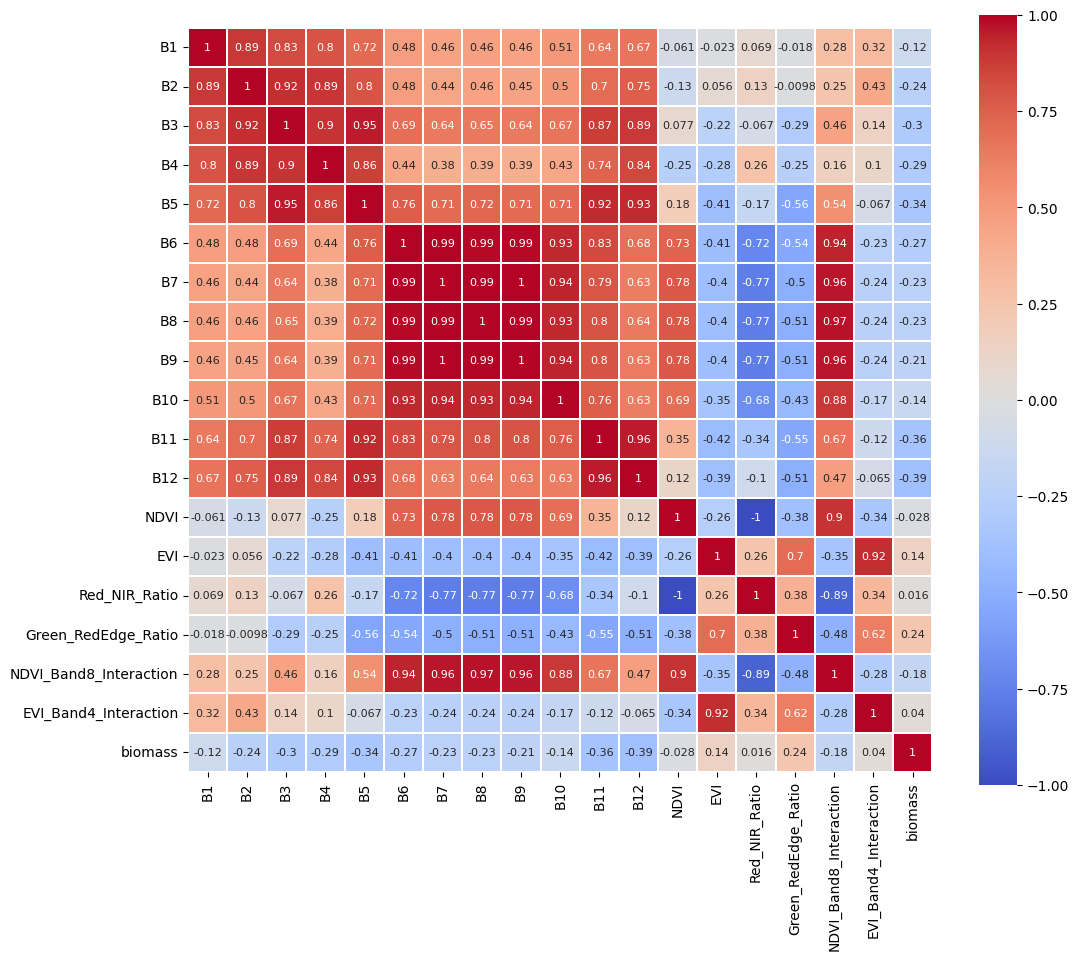

In [65]:

corr =scaled_df.corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr,
            cmap='coolwarm', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

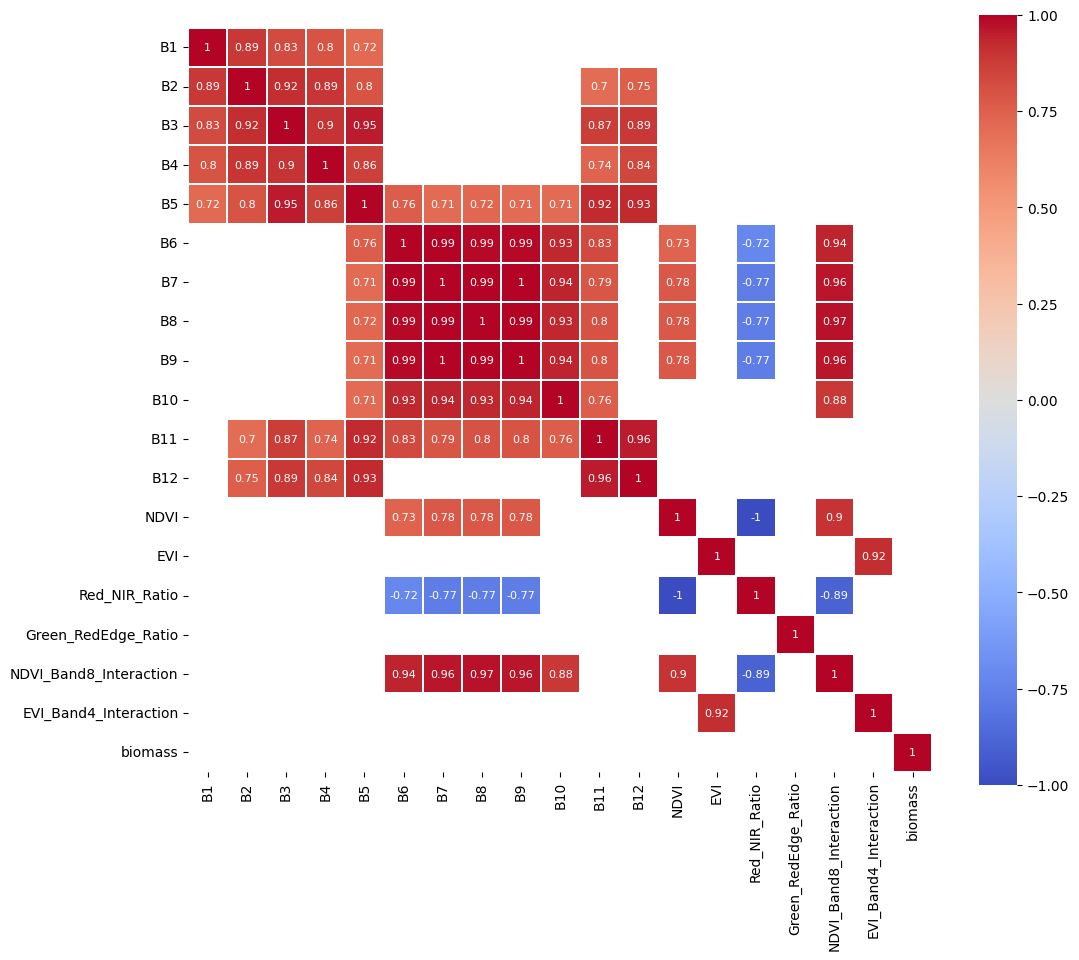

In [66]:
## only show correlations above threshold of 0.7

corr =scaled_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr[(corr >= 0.7) | (corr <= -0.7)],
            cmap='coolwarm', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

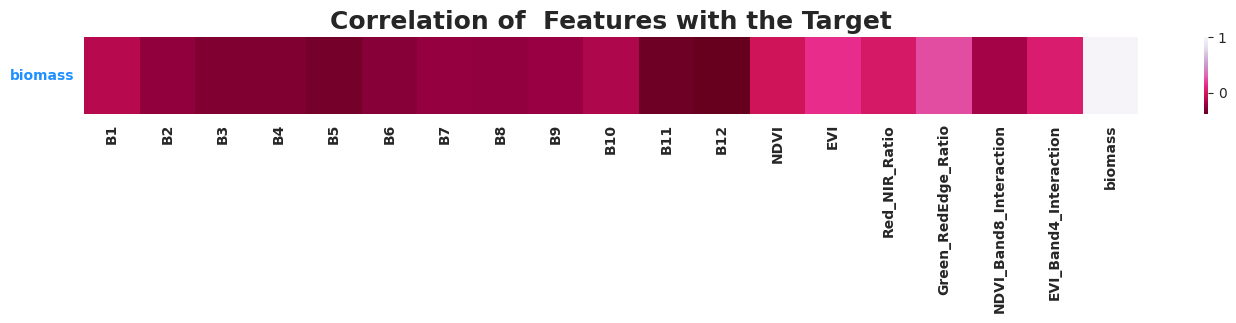

In [107]:


f, ax = plt.subplots(figsize = (17, 1))

sns.heatmap(corr.sort_values(by = ['biomass'], ascending = False).head(1), cmap='PuRd_r')

plt.title('Correlation of  Features with the Target', weight = 'bold', fontsize = 18)
plt.xticks(weight='bold')
plt.yticks(weight='bold', color='dodgerblue', rotation=0)

plt.show()

In [109]:
correlation = scaled_df.corr()['biomass'].sort_values(ascending = False).to_frame()

cmap = sns.light_palette("cyan", as_cmap = True)

s = correlation.style.background_gradient(cmap = cmap)

s

### Summary of Correlation Scores with Biomass
The insights from the correlation matrix reveals the relationship between the features and the target variable, biomass. Here are a few take aways.

* Positive Correlations:

  - **Green_RedEdge_Ratio: 0.237** - This feature has the strongest positive correlation with biomass among the evaluated features.
  - **EVI: 0.143** - The Enhanced Vegetation Index also shows a positive correlation, suggesting it may be beneficial in predicting biomass.


- Weak Positive to Neutral Correlations:

  - **EVI_Band4_Interaction: 0.040** - This feature shows a very weak positive correlation.
  - **Red_NIR_Ratio: 0.016** - This feature has an almost negligible correlation with biomass.


- Negative Correlations:

  * The majority of the features exhibit negative correlations with biomass, indicating that as these features increase, biomass tends to decrease:

    * B11: -0.387 - The strongest negative correlation with biomass.
    * B12: -0.388 - Very similar to B11, also indicating a strong negative relationship.
    * B4 (Red band): -0.292
    * B5: -0.336
    * B3 (Green band): -0.299
    * B6: -0.271
    * B2 (Blue band): -0.240
    * B7: -0.230
    * B9: -0.214
    * NDVI_Band8_Interaction: -0.176
    * B10: -0.141
    * B1: -0.116
    * NDVI: -0.028 (almost neutral)

  
Insights

* Strong Negative Relationship: Features like B11 and B12 have strong negative correlations with biomass, suggesting they may be less useful in predicting biomass if included in the model. This could indicate that these bands may capture noise or irrelevant information.

* Useful Positive Features: The features that show positive correlations (like Green_RedEdge_Ratio and EVI) could be more significant predictors of biomass and may warrant further investigation or inclusion in the model.

### Feature Selection


Let's analyse the skewness of the numerical features.

In [68]:
skewed_features = features.apply(lambda x : x.skew()).sort_values(ascending = False)
skew_features = pd.DataFrame({'Skew Value' : skewed_features})

skew_features

Skew Value
EVI_Band4_Interaction     2.215311
EVI                       1.803969
Red_NIR_Ratio             0.742626
B6                        0.695349
B10                       0.675747
B8                        0.643015
B7                        0.633825
B9                        0.623154
B12                       0.616831
NDVI_Band8_Interaction    0.596194
B4                        0.454657
B3                        0.381412
B2                        0.370155
B11                       0.344830
B5                        0.266223
B1                        0.166882
Green_RedEdge_Ratio      -0.316182
NDVI                     -0.549644

The features have varying degrees of asymmetry, with some highly skewed, indicating that transformations may be required.

In [72]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


# Check the skew of all numerical features
skewed_features = features.apply(lambda x: x.skew()).sort_values(ascending=False)

high_skew = skewed_features[abs(skewed_features) > 0.5]
skewed_features = high_skew.index

# Perform the Box-Cox transformation
for column in skewed_features:
    features[column] = boxcox1p(features[column], boxcox_normmax(features[column] + 1))



BracketError: The algorithm terminated without finding a valid bracket. Consider trying different initial points.

In [73]:
skewed_features

Index(['EVI_Band4_Interaction', 'EVI', 'Red_NIR_Ratio', 'B6', 'B10', 'B8',
       'B7', 'B9', 'B12', 'NDVI_Band8_Interaction', 'NDVI'],
      dtype='object')

In [71]:
features = fix_skew(features)
features.head()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1298: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, prob = _stats_py.pearsonr(xvals, yvals)


BracketError: The algorithm terminated without finding a valid bracket. Consider trying different initial points.

In [87]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


X = df.drop(columns=['biomass'])
y = df['biomass']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
### 1. Recursive Feature Elimination (RFE)

# Using RandomForestRegressor as the estimator
rf_estimator = RandomForestRegressor()
selector = RFE(rf_estimator, n_features_to_select=5)  # Specify the number of features you want to keep
selector = selector.fit(X_train, y_train)

# Get the selected features
rfe_selected_features = X_train.columns[selector.support_]
print("Selected features by RFE:")
print(rfe_selected_features)

# Evaluate RFE performance
y_pred_rfe = selector.predict(X_test)
print("RFE Mean Squared Error:", mean_squared_error(y_test, y_pred_rfe))



Selected features by RFE:
Index(['B5', 'B10', 'B11', 'B12', 'NDVI'], dtype='object')
RFE Mean Squared Error: 0.015697929197456637


In [89]:
### 2. L1 Regularization (Lasso)

lasso = Lasso(alpha=0.1)  # You can tune the alpha parameter
lasso.fit(X_train, y_train)

# Get coefficients
lasso_coefficients = pd.Series(lasso.coef_, index=X_train.columns)
lasso_selected_features = lasso_coefficients[lasso_coefficients != 0].index
print("Selected features by Lasso:")
print(lasso_selected_features)

# Evaluate Lasso performance
y_pred_lasso = lasso.predict(X_test)
print("Lasso Mean Squared Error:", mean_squared_error(y_test, y_pred_lasso))



Selected features by Lasso:
Index(['B1', 'B2', 'B3', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12',
       'NDVI_Band8_Interaction', 'EVI_Band4_Interaction'],
      dtype='object')
Lasso Mean Squared Error: 0.013776428965181957


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.391e-01, tolerance: 4.644e-04
  model = cd_fast.enet_coordinate_descent(


In [90]:
### 3. L2 Regularization (Ridge)

ridge = Ridge(alpha=0.1)  # You can tune the alpha parameter
ridge.fit(X_train, y_train)

# Get coefficients
ridge_coefficients = pd.Series(ridge.coef_, index=X_train.columns)
ridge_selected_features = ridge_coefficients[ridge_coefficients != 0].index
print("Selected features by Ridge:")
print(ridge_selected_features)

# Evaluate Ridge performance
y_pred_ridge = ridge.predict(X_test)
print("Ridge Mean Squared Error:", mean_squared_error(y_test, y_pred_ridge))


Selected features by Ridge:
Index(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11',
       'B12', 'NDVI', 'EVI', 'Red_NIR_Ratio', 'Green_RedEdge_Ratio',
       'NDVI_Band8_Interaction', 'EVI_Band4_Interaction'],
      dtype='object')
Ridge Mean Squared Error: 0.016414396794357997


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

# Assume X and y are the feature matrix and target variable
# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# Get feature names
feature_names = X.columns if hasattr(X, 'columns') else [f"Feature {i}" for i in range(X.shape[1])]

# Sort the feature importances in descending order
sorted_idx = np.argsort(importances)[::-1]

# Rearrange feature names and importances according to sorted index
sorted_importances = importances[sorted_idx]
sorted_feature_names = [feature_names[i] for i in sorted_idx]

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances, y=sorted_feature_names, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


In [ ]:
#Recursive Feature Elimination (RFE): This technique recursively removes the least important features, based on a model's performance.

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
rfe = RFE(estimator=model, n_features_to_select=5)  # Select the top 5 features
X_reduced = rfe.fit_transform(X, y)

pd.DataFrame(X_reduced).head()

0           1           2           3           4
0  1587.06250  4166.53125  5033.87500  3175.37500  2025.12500
1  1557.96875  3309.59375  4050.06250  3126.53125  2076.00000
2  1558.34375  4401.18750  5516.50000  3312.12500  2096.93750
3  1431.18750  3415.06250  4109.65625  2853.62500  1916.62500
4  1452.62500  4371.34375  5314.00000  3228.25000  2030.09375

In [ ]:
# Sequential Feature Selection: Adds or removes features sequentially based on model performance. It can be used for both forward and backward selection.
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

model = LinearRegression()
sfs = SequentialFeatureSelector(model, n_features_to_select=5, direction='forward')
X_reduced = sfs.fit_transform(X, y)


In [ ]:
#Lasso (L1 Regularization): Lasso regression applies L1 regularization,
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.1)  # Adjust alpha for regularization strength
model.fit(X, y)
importance = np.abs(model.coef_)
selected_features = np.where(importance > 0)[0]  # Features with non-zero coefficients
selected_features

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.236e-02, tolerance: 5.676e-04
  model = cd_fast.enet_coordinate_descent(


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming you've already removed duplicates and handled NaN values in X and y
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# List of regressors to try
regressors = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR(kernel='rbf'),
    "K-Nearest Neighbors Regressor": KNeighborsRegressor(n_neighbors=5)
}

# Store the results for comparison
results = []

# Train and evaluate each model
for name, model in regressors.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions on the test set

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store the results
    results.append({
        "Model": name,
        "Mean Squared Error": mse,
        "R-squared": r2
    })

# Convert the results to a DataFrame for easy comparison
results_df = pd.DataFrame(results)
print(results_df)


                           Model  Mean Squared Error  R-squared
0              Linear Regression            0.029017   0.245048
1        Random Forest Regressor            0.036088   0.061086
2    Gradient Boosting Regressor            0.043787  -0.139222
3       Support Vector Regressor            0.027618   0.281449
4  K-Nearest Neighbors Regressor            0.039785  -0.035099


1. **Summary of Findings**
*The predictive biomass model, trained using multispectral imagery from Sentinel-2 and biomass data from field plots, successfully provided biomass predictions across the reserve. The model performed well, with key spectral bands such as the near-infrared and red-edge bands proving crucial in predicting biomass values.

2. **Implications for Restoration Activities**
The biomass predictions can now be used to inform Rainforest Builder’s restoration activities. By identifying areas with lower biomass, efforts can be focused on regions that require immediate intervention. The model also helps in estimating carbon sequestration potential, aiding long-term conservation planning.

Challenges and Limitations
A few challenges were encountered during the project:

Data Limitations: The availability of biomass data was restricted to a single season, which may affect model generalization across other time periods.
Model Performance: Some bias was observed in predicting extreme biomass values, likely due to data imbalance.
Environmental Factors: Variability in tree species and terrain may introduce inaccuracies in biomass predictions.
Future Work
To enhance the model, future work could focus on:

Collecting biomass data across different seasons and forest types to improve model robustness.
Integrating advanced remote sensing techniques, such as LiDAR, to capture 3D forest structure and enhance prediction accuracy.
Experimenting with deep learning models for more complex pattern recognition and better predictive performance.
Scaling the model to cover other forest reserves and tropical forests globally.
Practical Implementation
The predictive model can be embedded into forest management systems to guide restoration efforts. By identifying areas with lower biomass, Rainforest Builder can prioritize interventions. The predictions can also be used to estimate carbon stocks and help with carbon credit calculations, further supporting conservation funding efforts.